# Preprocessing, Scaling & Encoding — Geometry, Optimization, and Feature Semantics

This notebook studies:

- How scaling reshapes the loss surface
- Why optimization conditioning matters
- How outliers distort MinMax scaling
- When to prefer StandardScaler vs RobustScaler
- Why categorical encoding requires semantic care

This is not cosmetic preprocessing.
It defines how models perceive space.


# Geometry of the Loss Surface

When optimizing linear models, we minimize:

$$
J(w) = \frac{1}{m} \sum_{i=1}^{m} L(y^{(i)}, f(x^{(i)}))
$$

If feature scales differ drastically:

$$
x_1 \in [0, 1], \quad x_2 \in [0, 10^6]
$$

The loss surface becomes elongated (ill-conditioned).

Gradient descent zig-zags inefficiently.

Scaling transforms the surface closer to spherical,
making optimization more direct.


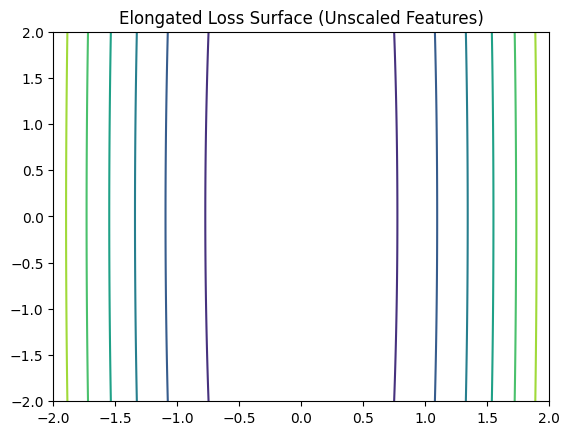

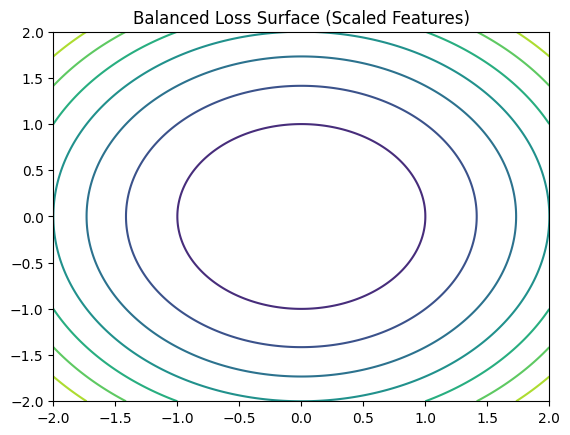

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Create grid
w1 = np.linspace(-2, 2, 200)
w2 = np.linspace(-2, 2, 200)
W1, W2 = np.meshgrid(w1, w2)

# Ill-conditioned loss surface (elongated)
Z_elongated = 100 * W1**2 + W2**2

# Well-conditioned loss surface
Z_balanced = W1**2 + W2**2

plt.figure()
plt.contour(W1, W2, Z_elongated)
plt.title("Elongated Loss Surface (Unscaled Features)")
plt.show()

plt.figure()
plt.contour(W1, W2, Z_balanced)
plt.title("Balanced Loss Surface (Scaled Features)")
plt.show()


The first contour plot shows elliptical geometry.

Gradient descent takes inefficient zig-zag paths.

The second plot shows near-circular contours.
Optimization becomes stable and direct.

Scaling improves numerical conditioning.


In [2]:
from sklearn.datasets import make_classification
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.model_selection import train_test_split

X, y = make_classification(
    n_samples=1000,
    n_features=2,
    n_informative=2,
    n_redundant=0,
    random_state=42
)

# Distort second feature
X[:, 1] *= 1000

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


# Outlier Squish Test

We insert one extreme outlier:

$$
x_{large} = 10^6
$$

We examine how MinMaxScaler compresses all other points.


In [3]:
X_outlier = X_train.copy()
X_outlier[0, 1] = 1_000_000


In [4]:
mm = MinMaxScaler()
X_mm = mm.fit_transform(X_outlier)

X_mm[:5]


array([[0.80518573, 1.        ],
       [0.46017077, 0.00617444],
       [0.52365265, 0.00287341],
       [0.31533752, 0.00278829],
       [0.37108967, 0.00392764]])

In [5]:
np.min(X_mm[:,1]), np.max(X_mm[:,1])


(np.float64(0.0), np.float64(1.0))

Observe that nearly all values collapse toward 0.

Because MinMax scaling uses:

$$
x' = \frac{x - x_{min}}{x_{max} - x_{min}}
$$

One extreme outlier stretches the denominator.

Result:
99% of points become numerically compressed.

This explains why MinMaxScaler is sensitive to outliers.


In [6]:
std = StandardScaler()
rob = RobustScaler()

X_std = std.fit_transform(X_outlier)
X_rob = rob.fit_transform(X_outlier)

np.mean(X_std[:,1]), np.median(X_rob[:,1])


(np.float64(-1.9984014443252817e-17), np.float64(0.0))

RobustScaler uses:

$$
x' = \frac{x - \text{median}}{IQR}
$$

where IQR = interquartile range.

This makes it resistant to extreme outliers.

Professional rule:
- Clean data → StandardScaler
- Outlier-heavy data → RobustScaler


# Categorical Encoding

Models operate on numbers.

But categories are not inherently numeric.

Encoding must preserve semantic meaning.

Bad encoding introduces false mathematical relationships.


In [7]:
import pandas as pd

df_cat = pd.DataFrame({
    "color": ["Red", "Blue", "Green", "Red", "Blue"],
    "price": [10, 15, 20, 12, 18]
})

df_cat


,color,price
0,Red,10
1,Blue,15
2,Green,20
3,Red,12
4,Blue,18


In [8]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
df_cat["color_label"] = le.fit_transform(df_cat["color"])

df_cat


,color,price,color_label
0,Red,10,2
1,Blue,15,0
2,Green,20,1
3,Red,12,2
4,Blue,18,0


LabelEncoder produces:

Red = 2
Blue = 0
Green = 1

This implies:

$$
0 < 1 < 2
$$

But colors have no natural order.

Distance-based or linear models will treat:

Red > Green > Blue

This is mathematically incorrect.


In [9]:
from sklearn.preprocessing import OneHotEncoder

ohe = OneHotEncoder(sparse_output=False)
encoded = ohe.fit_transform(df_cat[["color"]])

encoded


array([[0., 0., 1.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [1., 0., 0.]])

One-Hot Encoding creates orthogonal vectors:

Red   → [1,0,0]
Blue  → [0,1,0]
Green → [0,0,1]

No implied ordering.
No artificial distance distortion.

Professional rule:
- Nominal categories → OneHotEncoder
- Ordinal categories (Low < Medium < High) → OrdinalEncoder


# Encoding Rules

Do NOT use LabelEncoder on feature columns.

LabelEncoder is intended for target labels.

Feature encoding rules:

Nominal (unordered) → OneHotEncoder  
Ordinal (ordered) → OrdinalEncoder  

Incorrect encoding injects false geometry into feature space.


# Final Checklist - Day 3 Mastery

You should now understand:

- How scaling reshapes optimization geometry
- Why MinMax scaling fails under outliers
- Why RobustScaler exists
- Why tree models ignore feature scaling
- Why encoding semantics matter
- Why LabelEncoder is dangerous for nominal features

If you can explain these without hesitation,
Day 3 is complete.
